In [1]:
import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")

import Plib.Stats.Timeseries as su
import Plib.Stats.Timeseries as flt
import Plib.Signals.Filters as sflt
import Plib.Futures.TermStructure as ts
import Plib.DataFarm.Norgate as ng
import Plib.Utils.Tools as tl
import Plib.Futures.TradersCommitment as f
import Plib.Plotting.Plots as pl

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("crude_oil_prices.csv", index_col=0, parse_dates=True)
df.columns=['Adj Close']
df.index=pd.to_datetime(df.index, errors='coerce')
df=df.asfreq(freq='d', method='bfill')
df2=df.copy()
df2=df2[['Adj Close']]
df2['log_returns']= np.log(df2['Adj Close'] / df2['Adj Close'].shift(1))
df2.columns=['adj_close','log_returns']


# Normality Test


A standard assumption in finance models is that returns are normally distributed. Numerous studies have however shown empirically that this is not quite true. Specifically,

Left skewed : Gains and loss distributions are not symmetrical. We see longer left tails compared to the right tails. The large negative returns are higher in magnitude compared to the large positive returns. The mean is less than the median. Seen in negatively skewed distributions. Confirmed by the coefficient of skewness (which is negative).

Excess kurtosis : The distribution is fat at the tails and higher than normal peaks. Excess kurtosis seen (anything above 0 is deemed as excess kurtosis. Normal distribution has a kurtosis of 0 when measured using the pandas kurtosis method).

There is a visible difference in the shape of the returns histogram and the Gaussian (normal) distribution curve. The peak is higher in the histogram than the normal curve.
The left tail of the distribution is longer.

Q-Q plots are used to compare empirical data to theoretical distributions. They are helpful in finding deviations at the tails. If we find that the dots are more or less on the red line, then it means that the data (in this case returns) is normally distributed.
There is drift at both ends of the tails. This means that we have fatter tails violating the normality assumption. The size of the drift is higher on the left side of the plot than on the right side. This means that we observe large drops in returns but not equally large growths in returns.

------------------------ Summary Statistics for CRUDE Log Returns ------------------------
Range of dates: 2003-01-02 to 2020-07-03
Number of observations: 6393
Mean: 0.0001
Median: 0.0000
Min: -0.3312
Max: 0.2287
Standard Deviation: 0.0174
Skewness: -1.4489
Kurtosis: 59.6624
Jarque-Bera statistic: 948913.31 with p-value: 0.00
Returns are likely not normally distributed.


BY WEEK mean Date 
 
 Friday 
 0.000600 
 
 
 Monday 
 0.000000 
 
 
 Saturday 
 -0.001200 
 
 
 Sunday 
 0.000000 
 
 
 Thursday 
 0.002200 
 
 
 Tuesday 
 -0.001100 
 
 
 Wednesday 
 -0.000100 
 
            BY MONTH mean Date 
 
 April 
 0.000800 
 
 
 August 
 -0.000200 
 
 
 December 
 -0.000600 
 
 
 February 
 0.001400 
 
 
 January 
 0.000400 
 
 
 July 
 0.000500 
 
 
 June 
 0.000500 
 
 
 March 
 -0.000900 
 
 
 May 
 0.001400 
 
 
 November 
 -0.001300 
 
 
 October 
 -0.000800 
 
 
 September 
 -0.000600 
 
            BY QUARTER mean Date 
 
 December 
 -0.000900 
 
 
 June 
 0.000900 
 
 
 March 
 0.000300 
 
 
 September 
 0.002000 
 
            BY SEMESTER mean Date 
 
 December 
 0.000400 
 
 
 June 
 0.002600

------------------------------------------------------------------------------------------


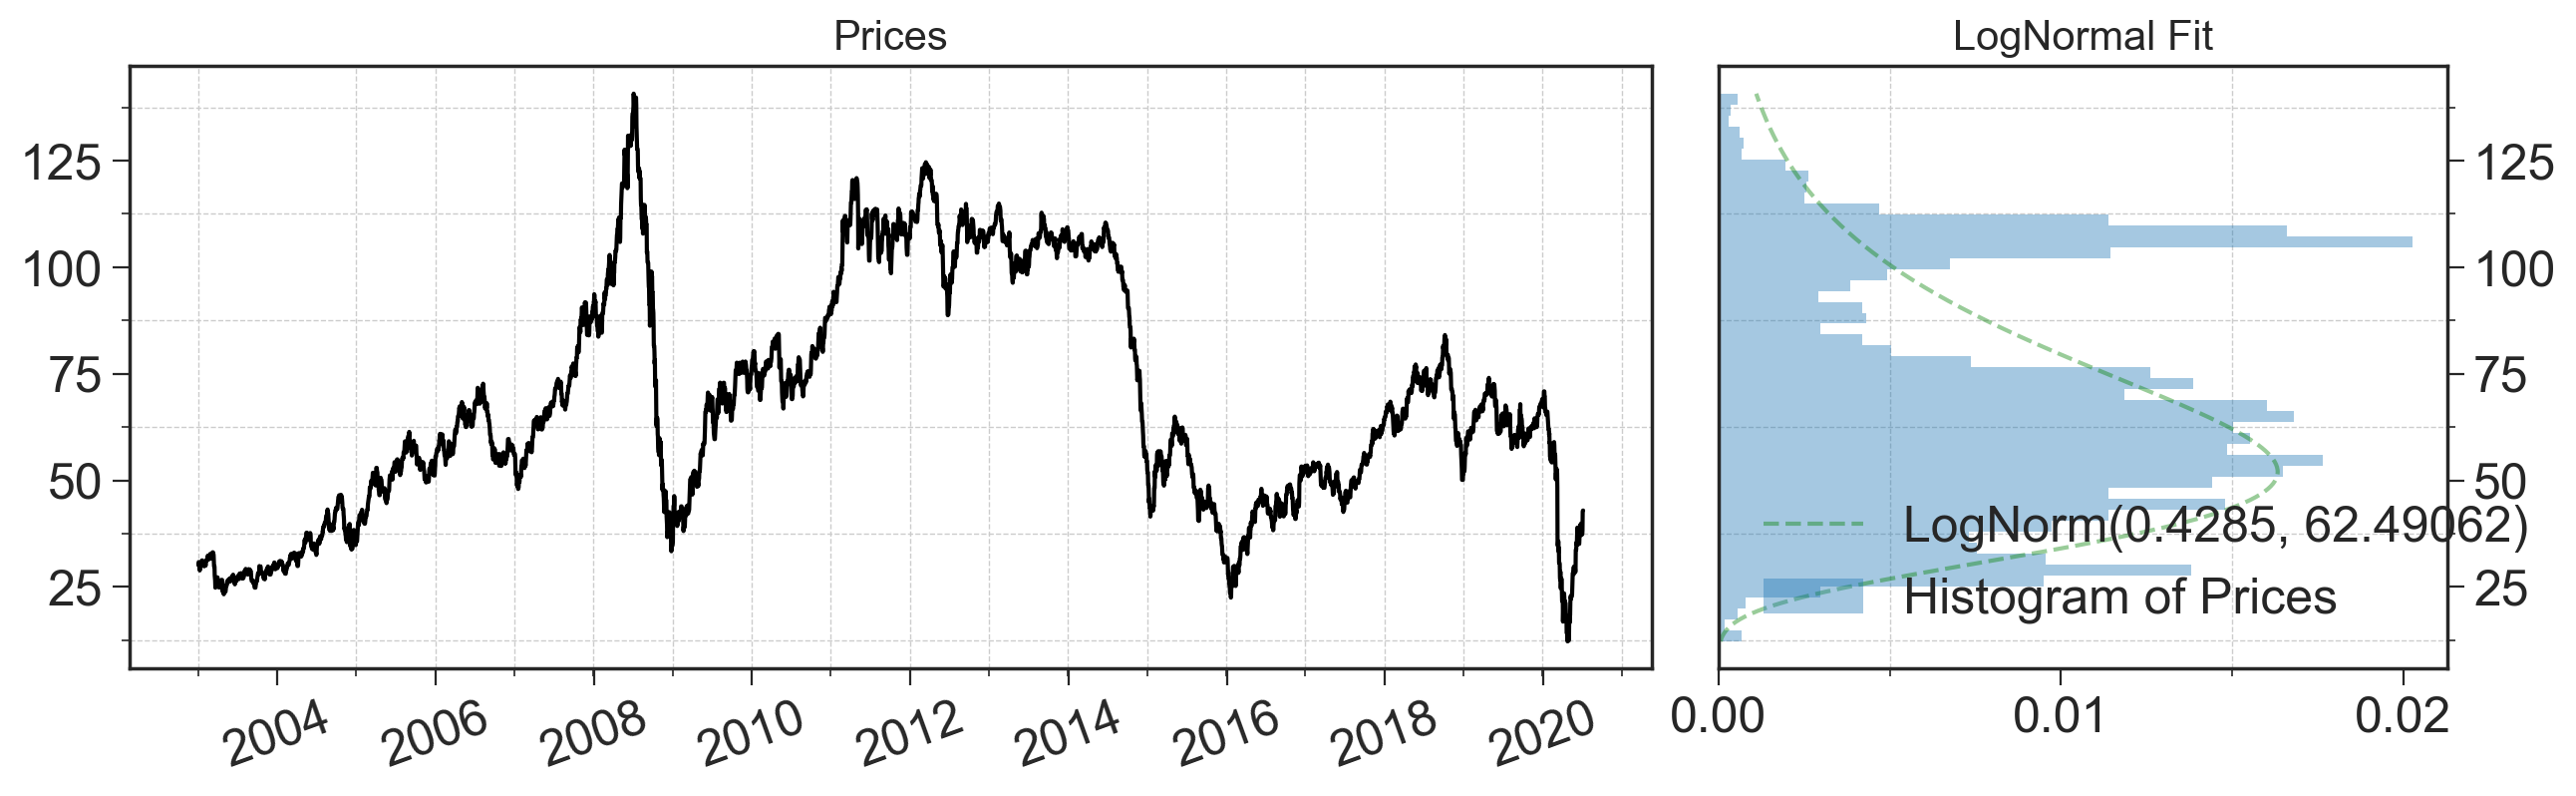

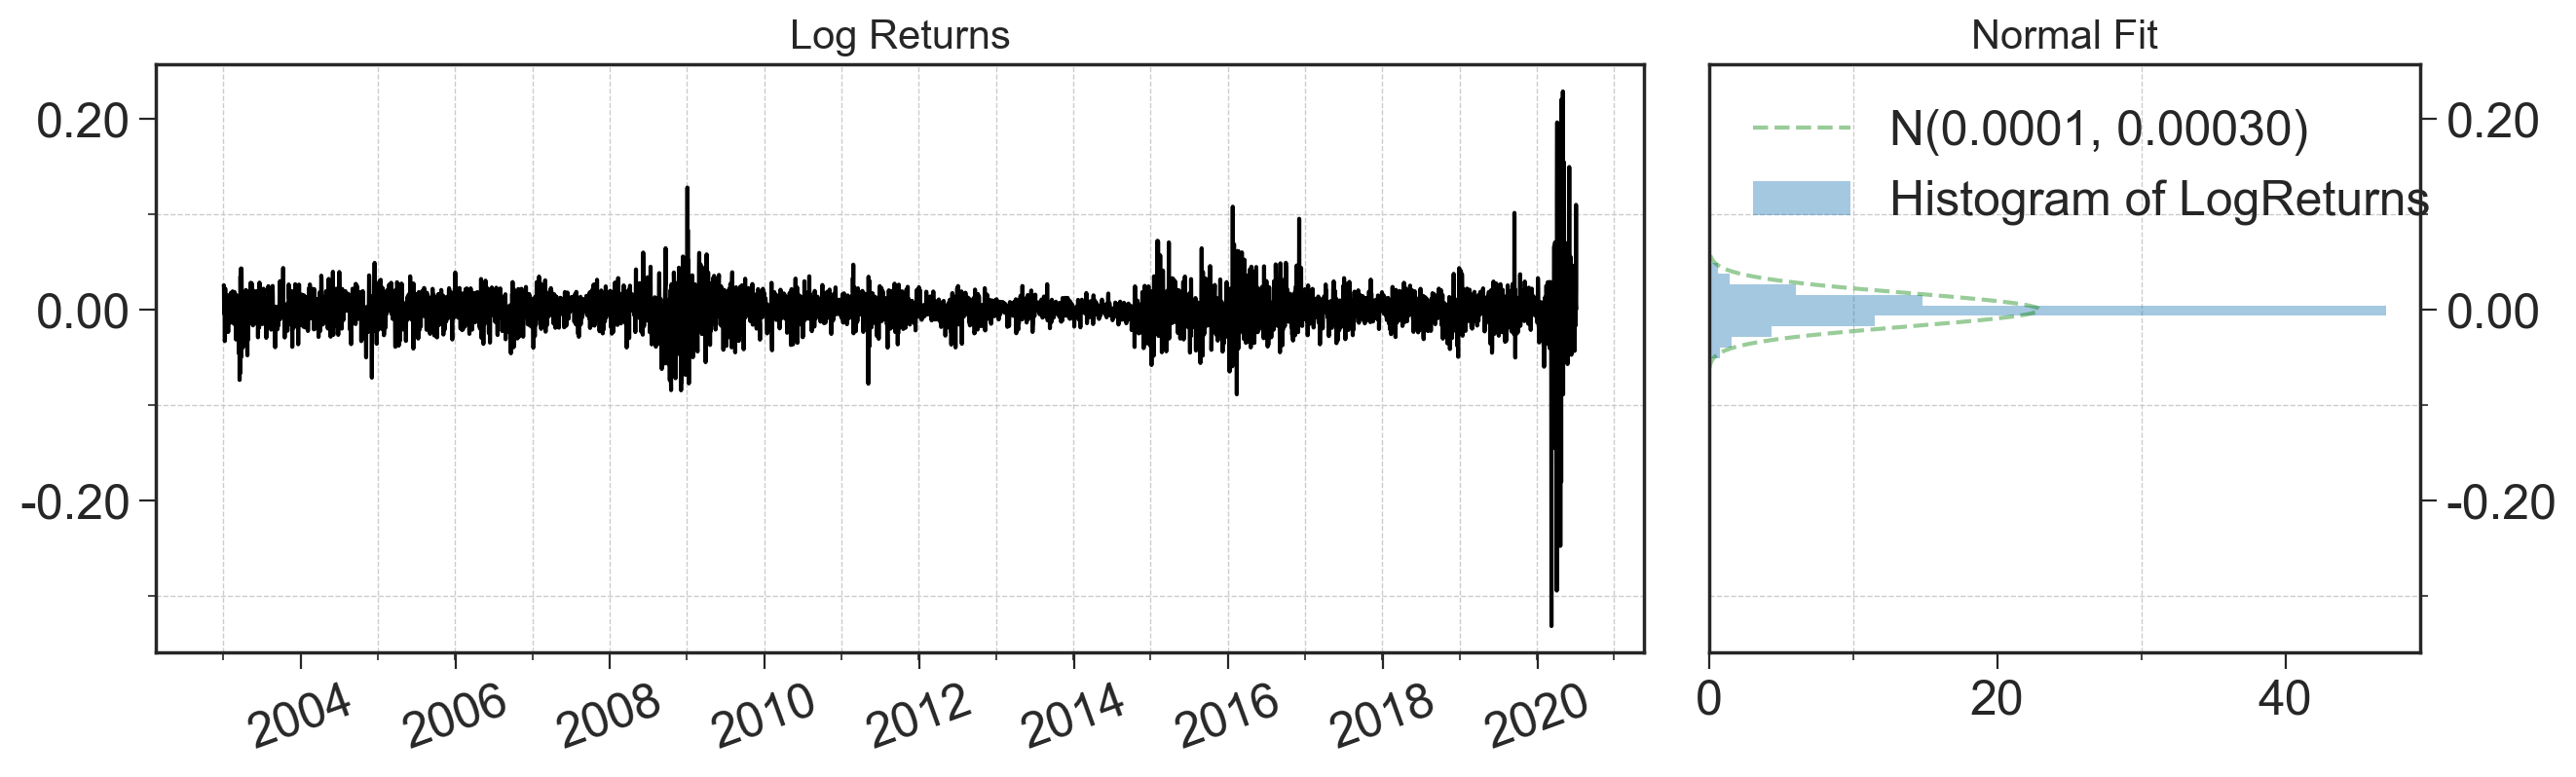

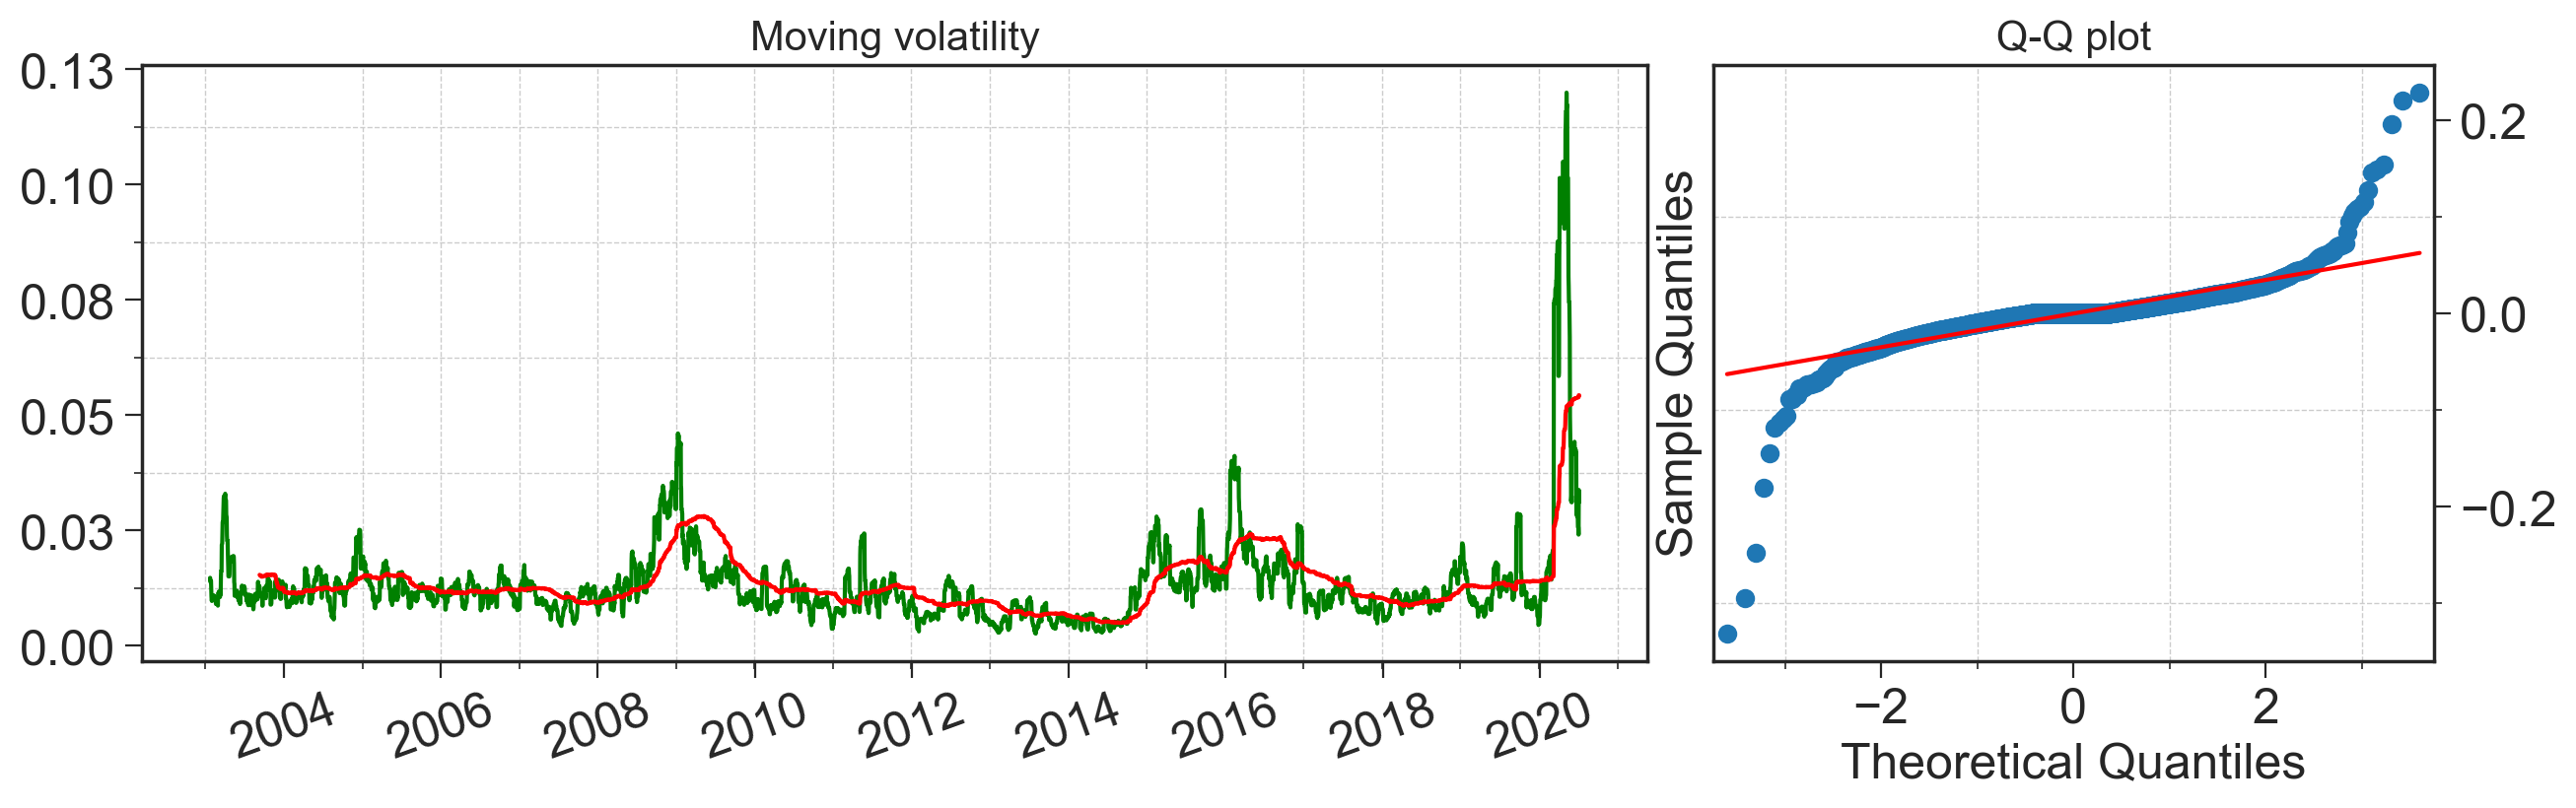

In [4]:
## Normality test with plots and Jarque-Bera test
## If the test statistic is very large and the p-value is less than 5%, we infer that 
## the data is not normally distributed.

rt=flt.normTest(df.copy(),title='CRUDE')

## Detrending to determine price bands for change of direction

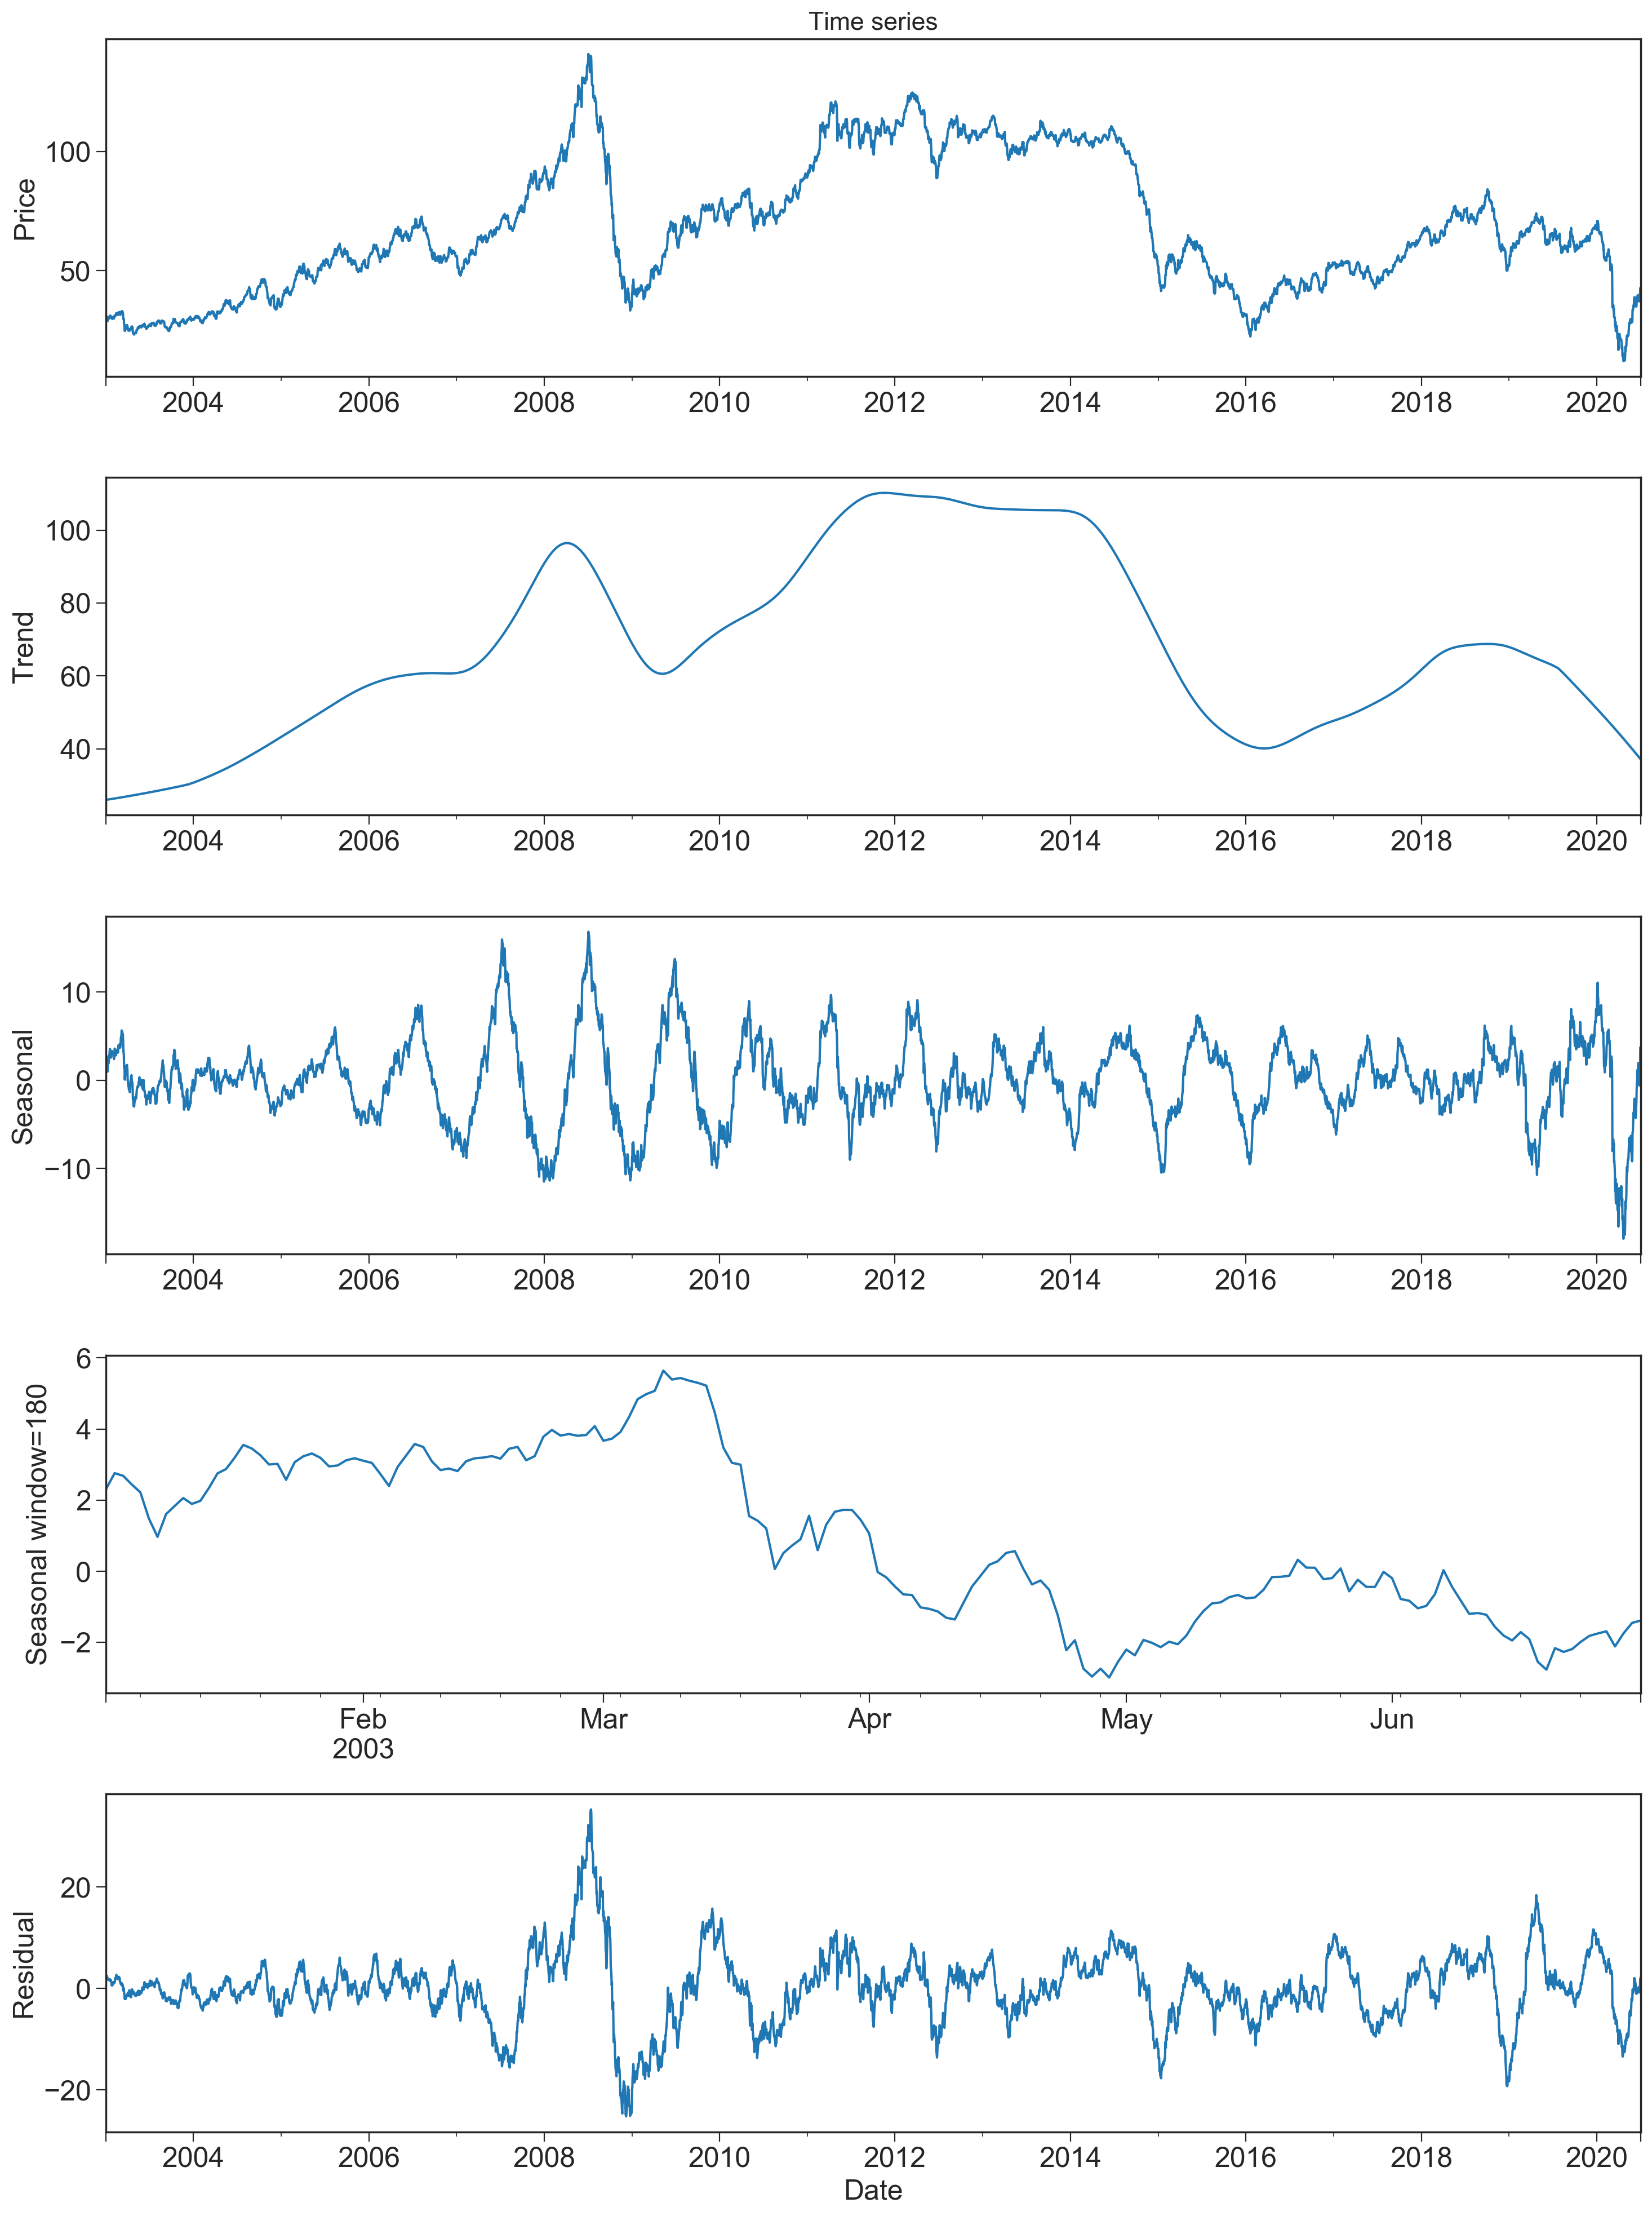

In [5]:
res=sflt.STLSeriesDecomp(df2.copy(),lbl='adj_close',freq=360, w=180, fs=(15,20))

------------------------ Summary Statistics for CRUDE Log Returns ------------------------
Range of dates: 2003-01-02 to 2020-07-03
Number of observations: 6393
Mean: 0.0199
Median: 0.0005
Min: -5.3220
Max: 7.4069
Standard Deviation: 0.5601
Skewness: 2.0929
Kurtosis: 34.3152
Jarque-Bera statistic: 317822.74 with p-value: 0.00
Returns are likely not normally distributed.


BY WEEK mean Date 
 
 Friday 
 0.035600 
 
 
 Monday 
 0.007900 
 
 
 Saturday 
 0.021700 
 
 
 Sunday 
 0.001800 
 
 
 Thursday 
 0.036800 
 
 
 Tuesday 
 0.026300 
 
 
 Wednesday 
 0.009400 
 
            BY MONTH mean Date 
 
 April 
 0.081600 
 
 
 August 
 0.012500 
 
 
 December 
 -0.025300 
 
 
 February 
 0.030200 
 
 
 January 
 0.016900 
 
 
 July 
 0.007300 
 
 
 June 
 0.012900 
 
 
 March 
 0.025200 
 
 
 May 
 0.043000 
 
 
 November 
 -0.010400 
 
 
 October 
 -0.012900 
 
 
 September 
 0.056000 
 
            BY QUARTER mean Date 
 
 December 
 -0.016300 
 
 
 June 
 0.045800 
 
 
 March 
 0.024000 
 
 
 September 
 0.057300 
 
            BY SEMESTER mean Date 
 
 December 
 -0.062900 
 
 
 June 
 -0.128100

------------------------------------------------------------------------------------------


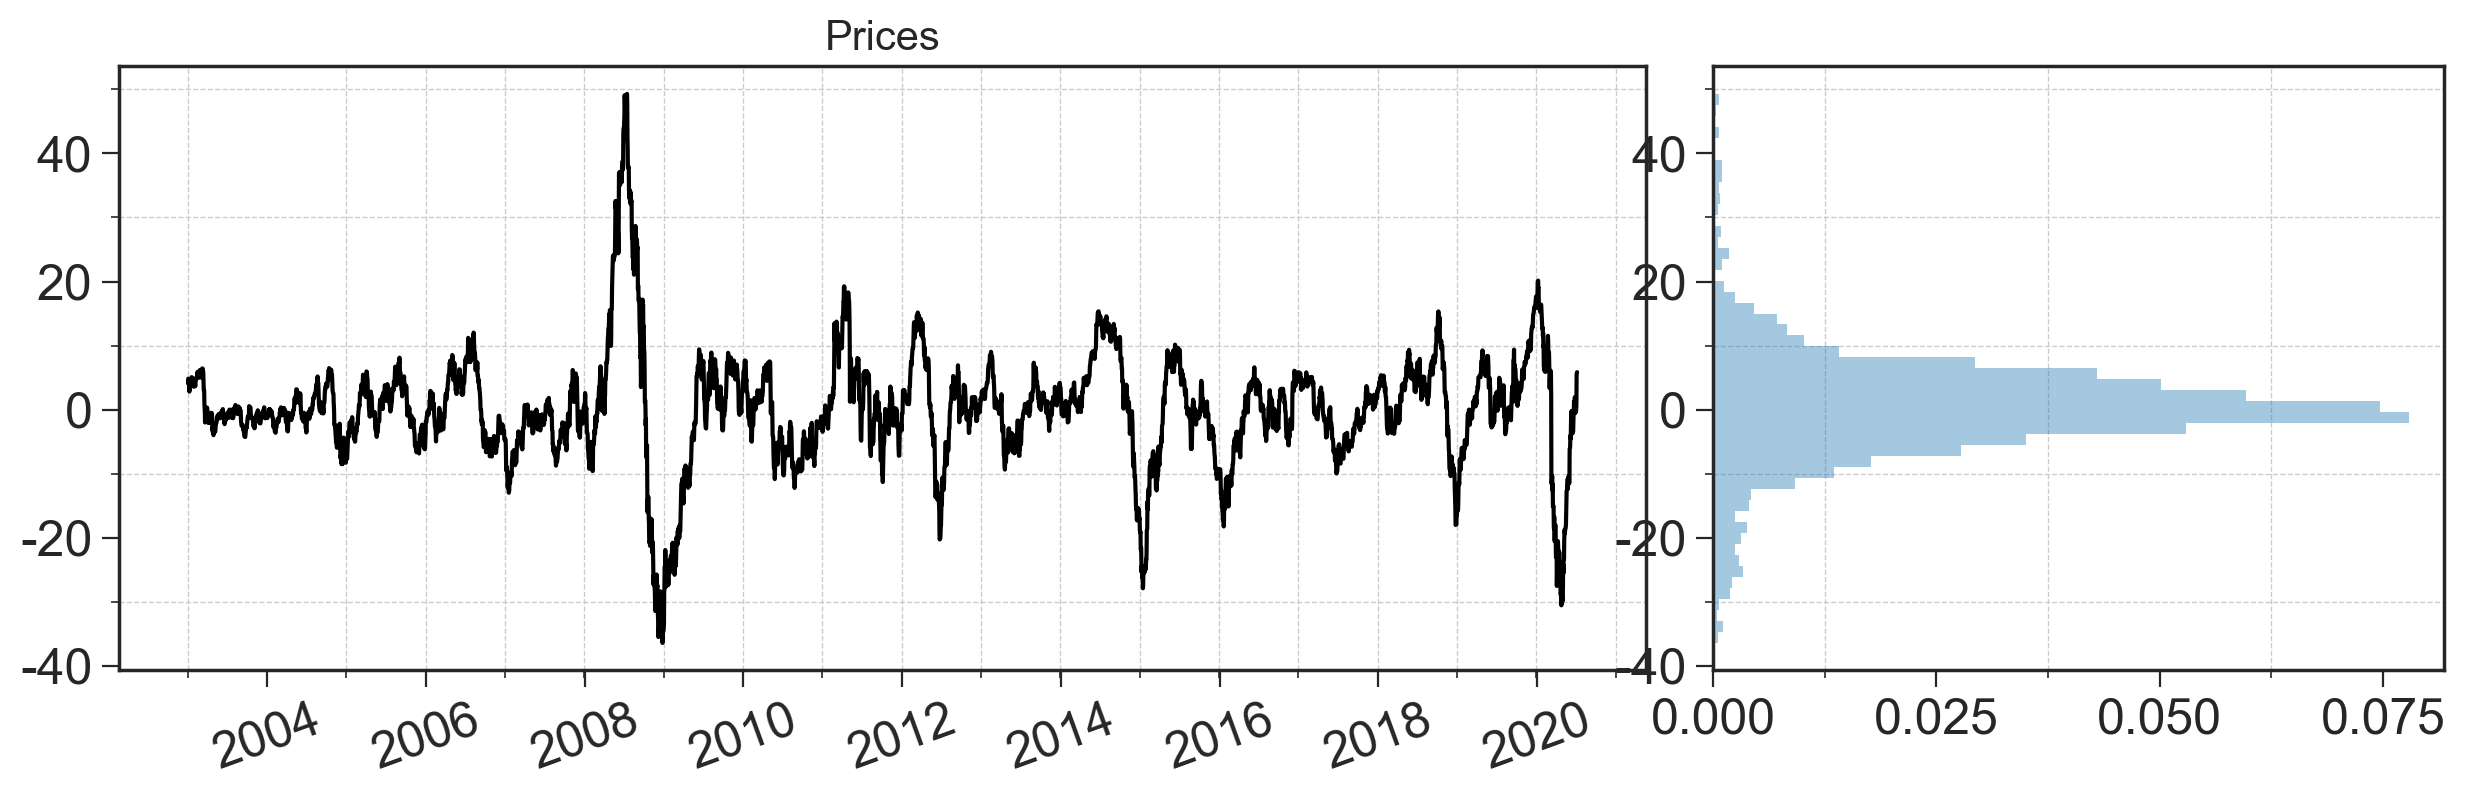

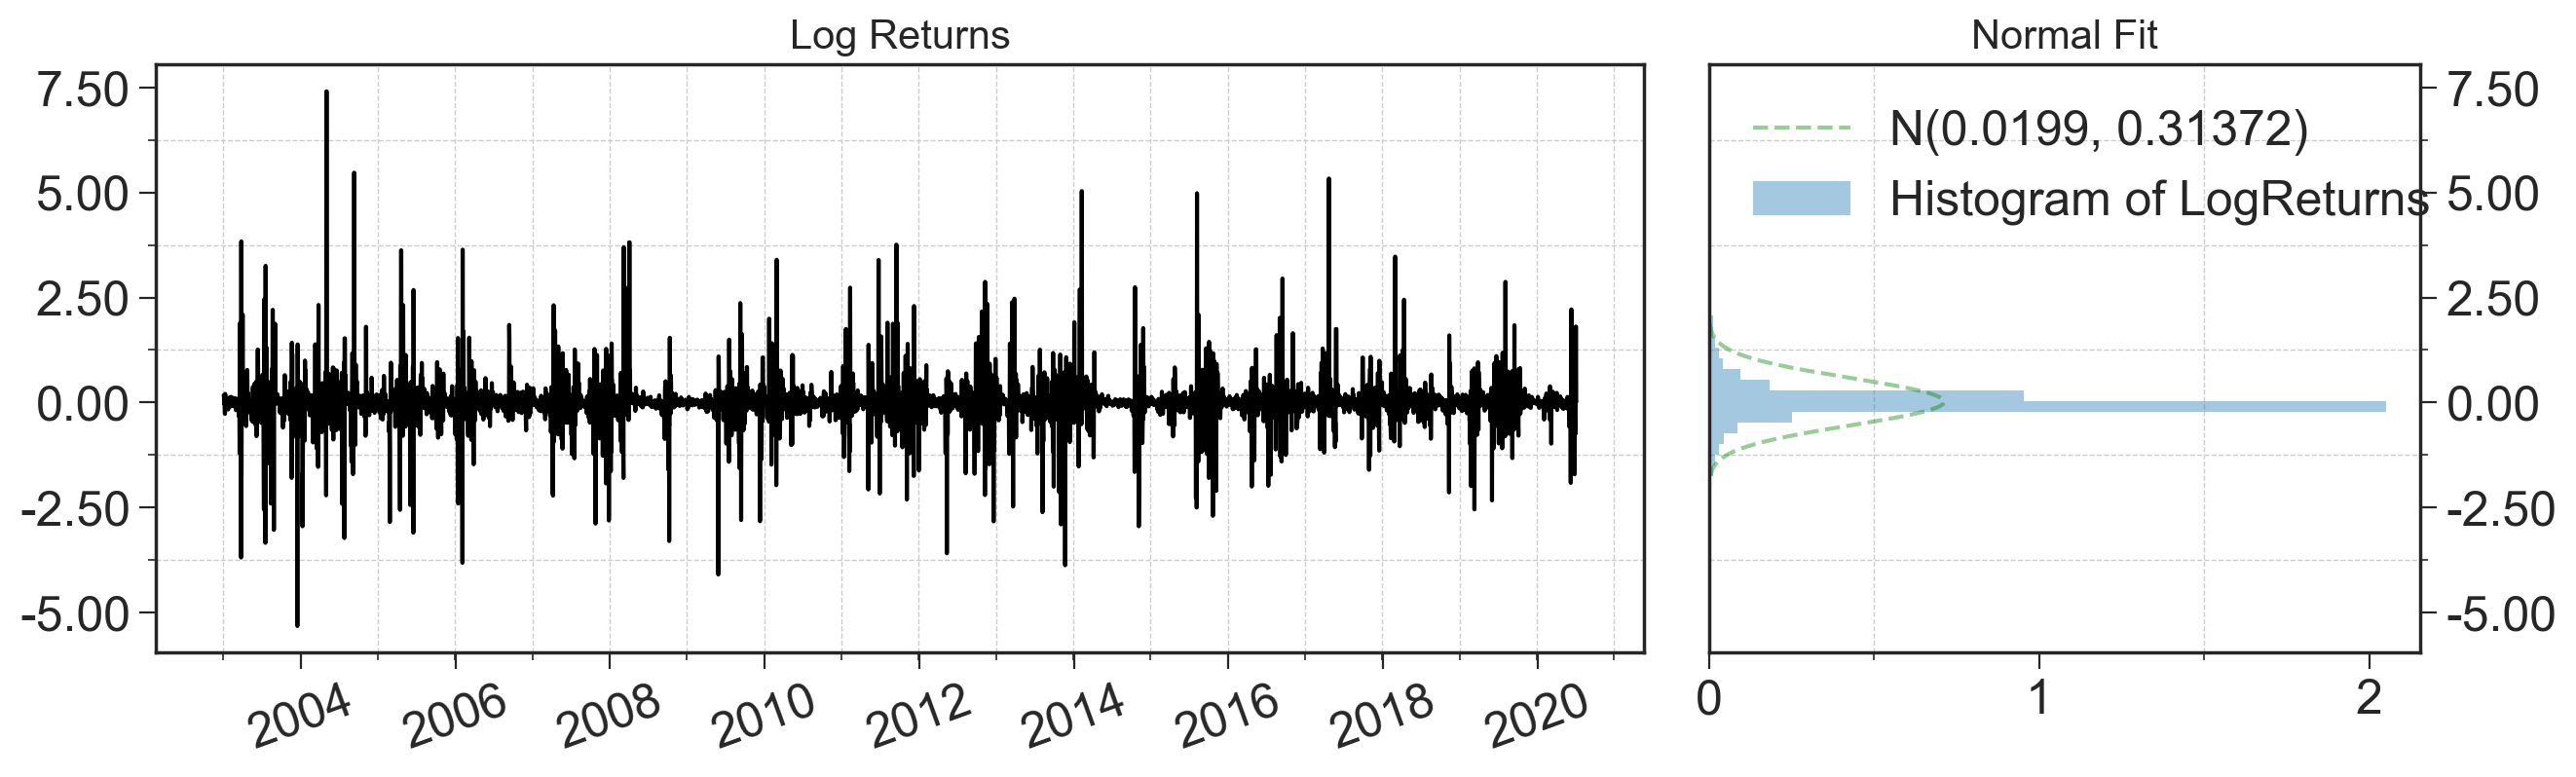

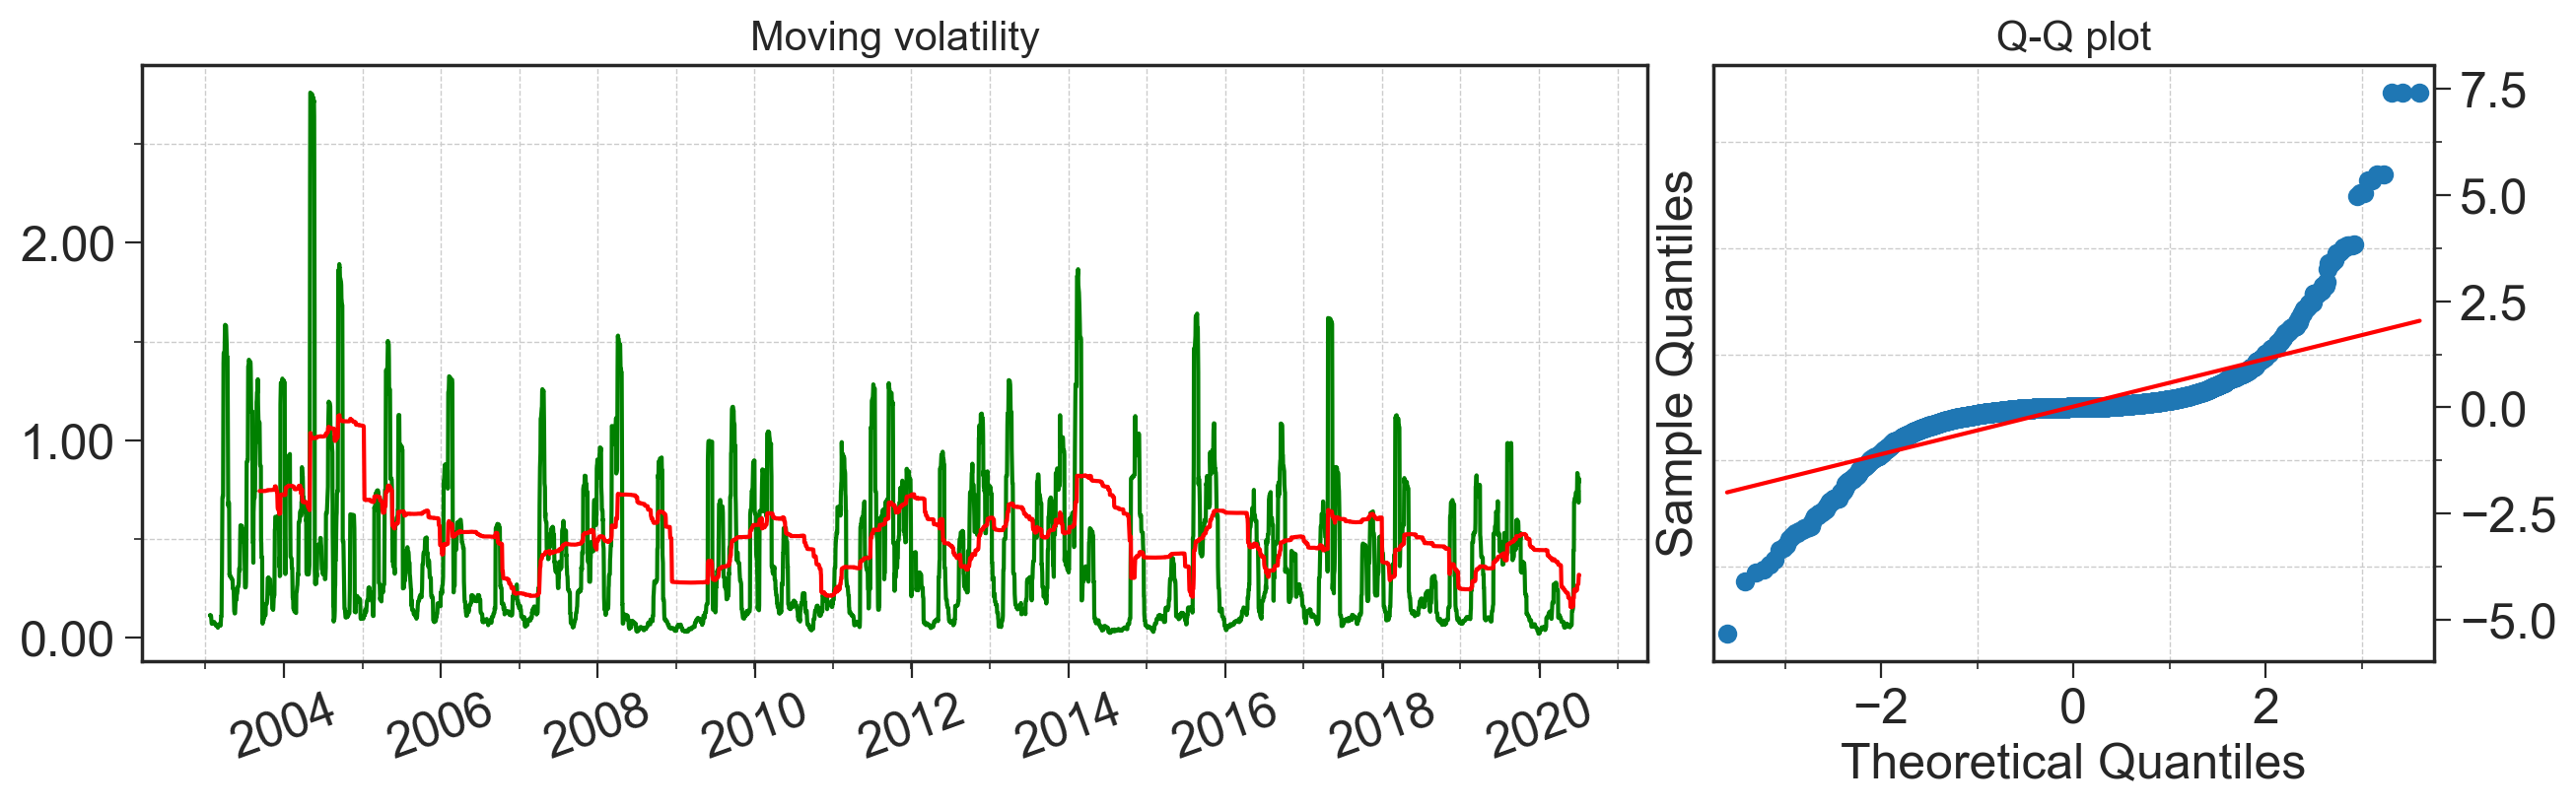

In [6]:
oil=df.copy()
oil['Adj Close']=oil['Adj Close']-res['STL_trend']
oil.index=pd.to_datetime(oil.index, errors='coerce')
oil=oil.asfreq(freq='d', method='bfill')
rt=flt.normTest(oil.copy(),title='CRUDE')

In [7]:
#res.keys()
flt.unit_root_tests(oil['Adj Close'], ci=0.05,table=True)
flt.jarquebera(res['STL_residual'], ci=0.05)

-------------------- Unit Root Tests -----------------------------
Results of Dickey-Fuller Test:
Test Statistic                -6.144757e+00
p-value                        7.815758e-08
#Lags Used                     2.800000e+01
Number of Observations Used    6.364000e+03
Critical Value (1%)           -3.431378e+00
Critical Value (5%)           -2.861994e+00
Critical Value (10%)          -2.567012e+00
dtype: float64
The series is stationary

Results of KPSS Test:
Test Statistic            0.024498
p-value                   0.100000
Lags Used                50.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
The series is stationary
------------------------------------------------------------------
Jarque-Bera statistic: 1675.05 with p-value: 0.00
Residuals are likely not normally distributed.


/Users/rob/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Iteration:      1,   Func. Count:     10,   Neg. LLF: 39539.59866919755
Iteration:      2,   Func. Count:     23,   Neg. LLF: 19271550.7063646
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8257.151656836411
Iteration:      4,   Func. Count:     44,   Neg. LLF: 8062.4746501266845
Iteration:      5,   Func. Count:     53,   Neg. LLF: 8236.303082002629
Iteration:      6,   Func. Count:     64,   Neg. LLF: 11005.136656095967
Iteration:      7,   Func. Count:     76,   Neg. LLF: 9344.762472114115
Iteration:      8,   Func. Count:     87,   Neg. LLF: 8282.33762666257
Iteration:      9,   Func. Count:     97,   Neg. LLF: 8047.94942252703
Iteration:     10,   Func. Count:    106,   Neg. LLF: 8339.138991587442
Iteration:     11,   Func. Count:    117,   Neg. LLF: 8047.301442014554
Iteration:     12,   Func. Count:    126,   Neg. LLF: 8047.2519882059005
Iteration:     13,   Func. Count:    135,   Neg. LLF: 8047.25120499148
Iteration:     14,   Func. Count:    144,   Neg. LLF: 8047.250905

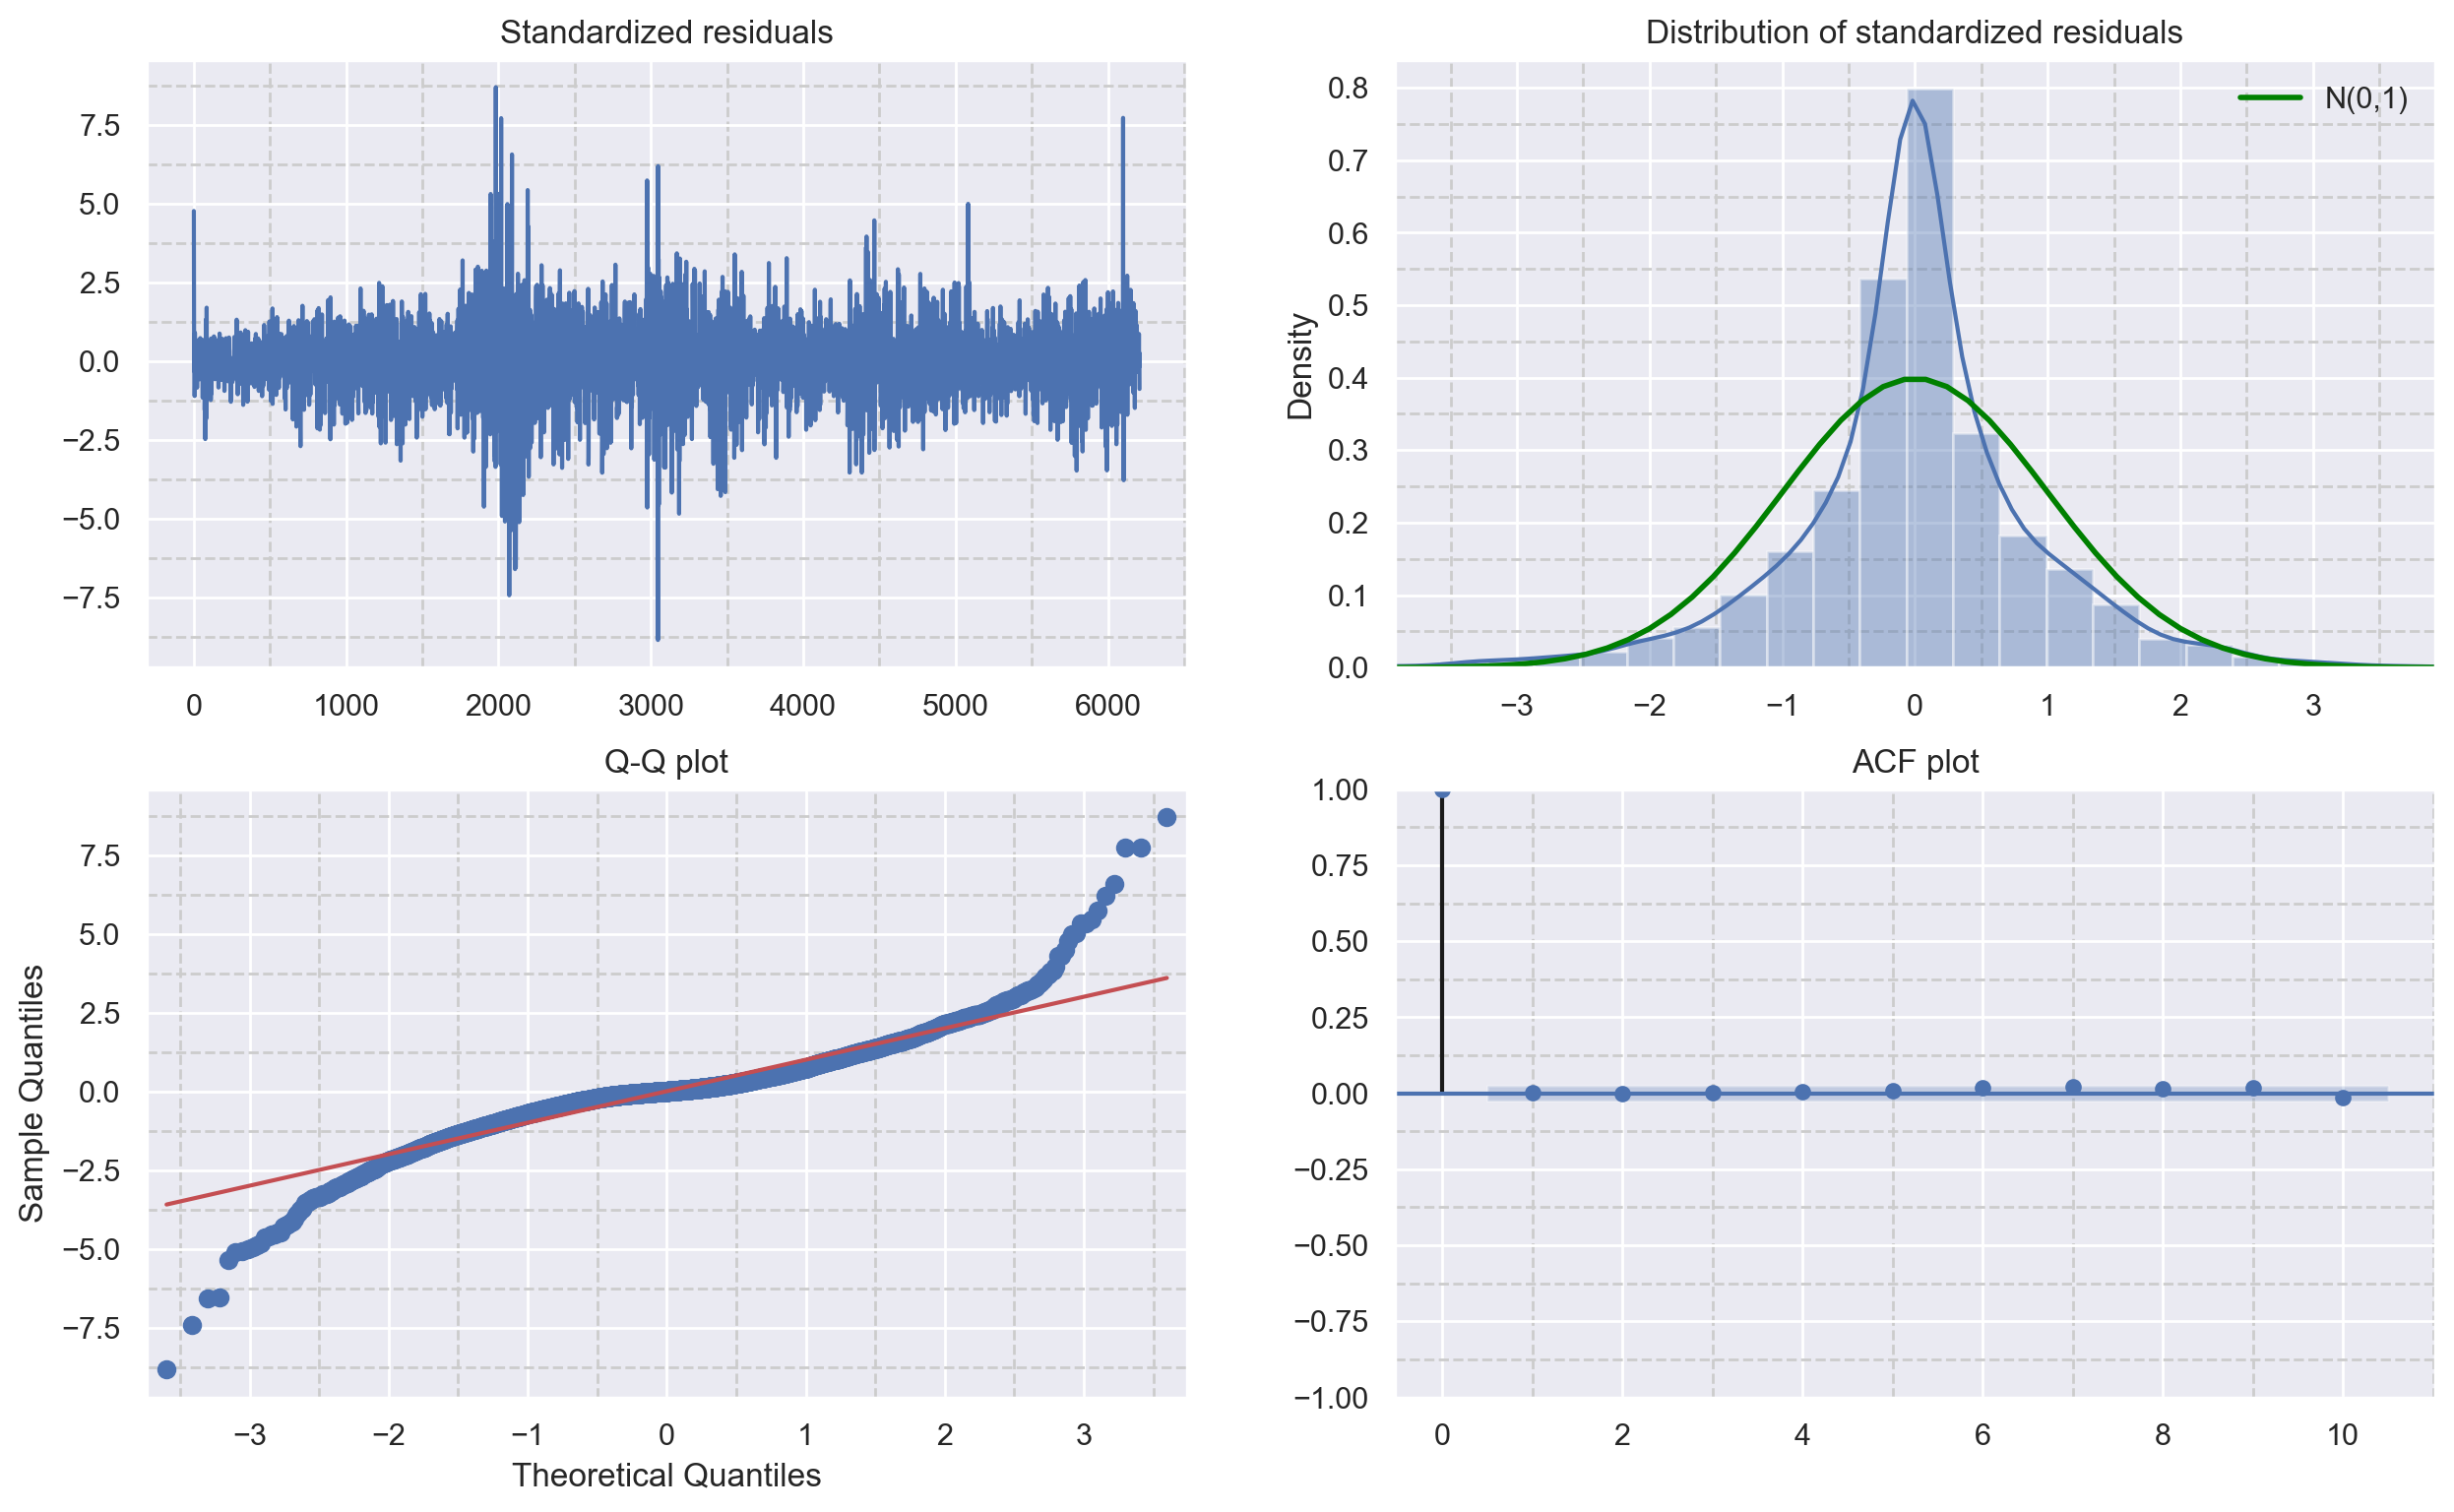

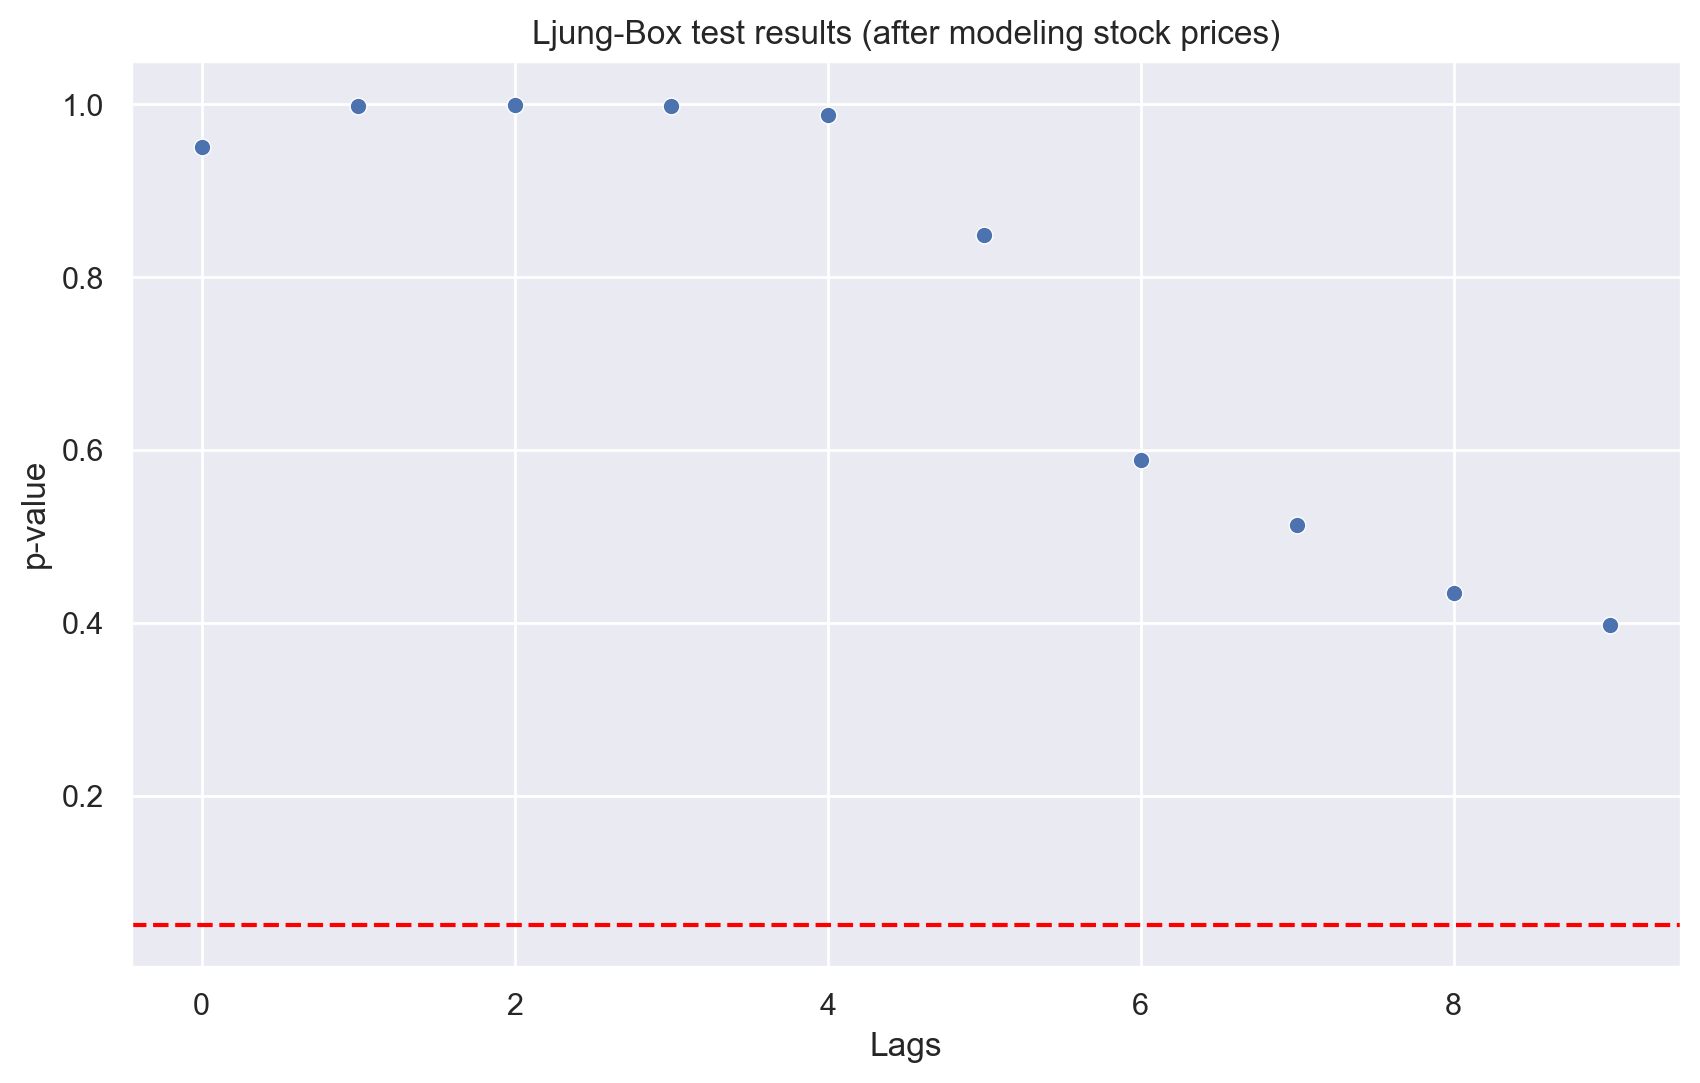

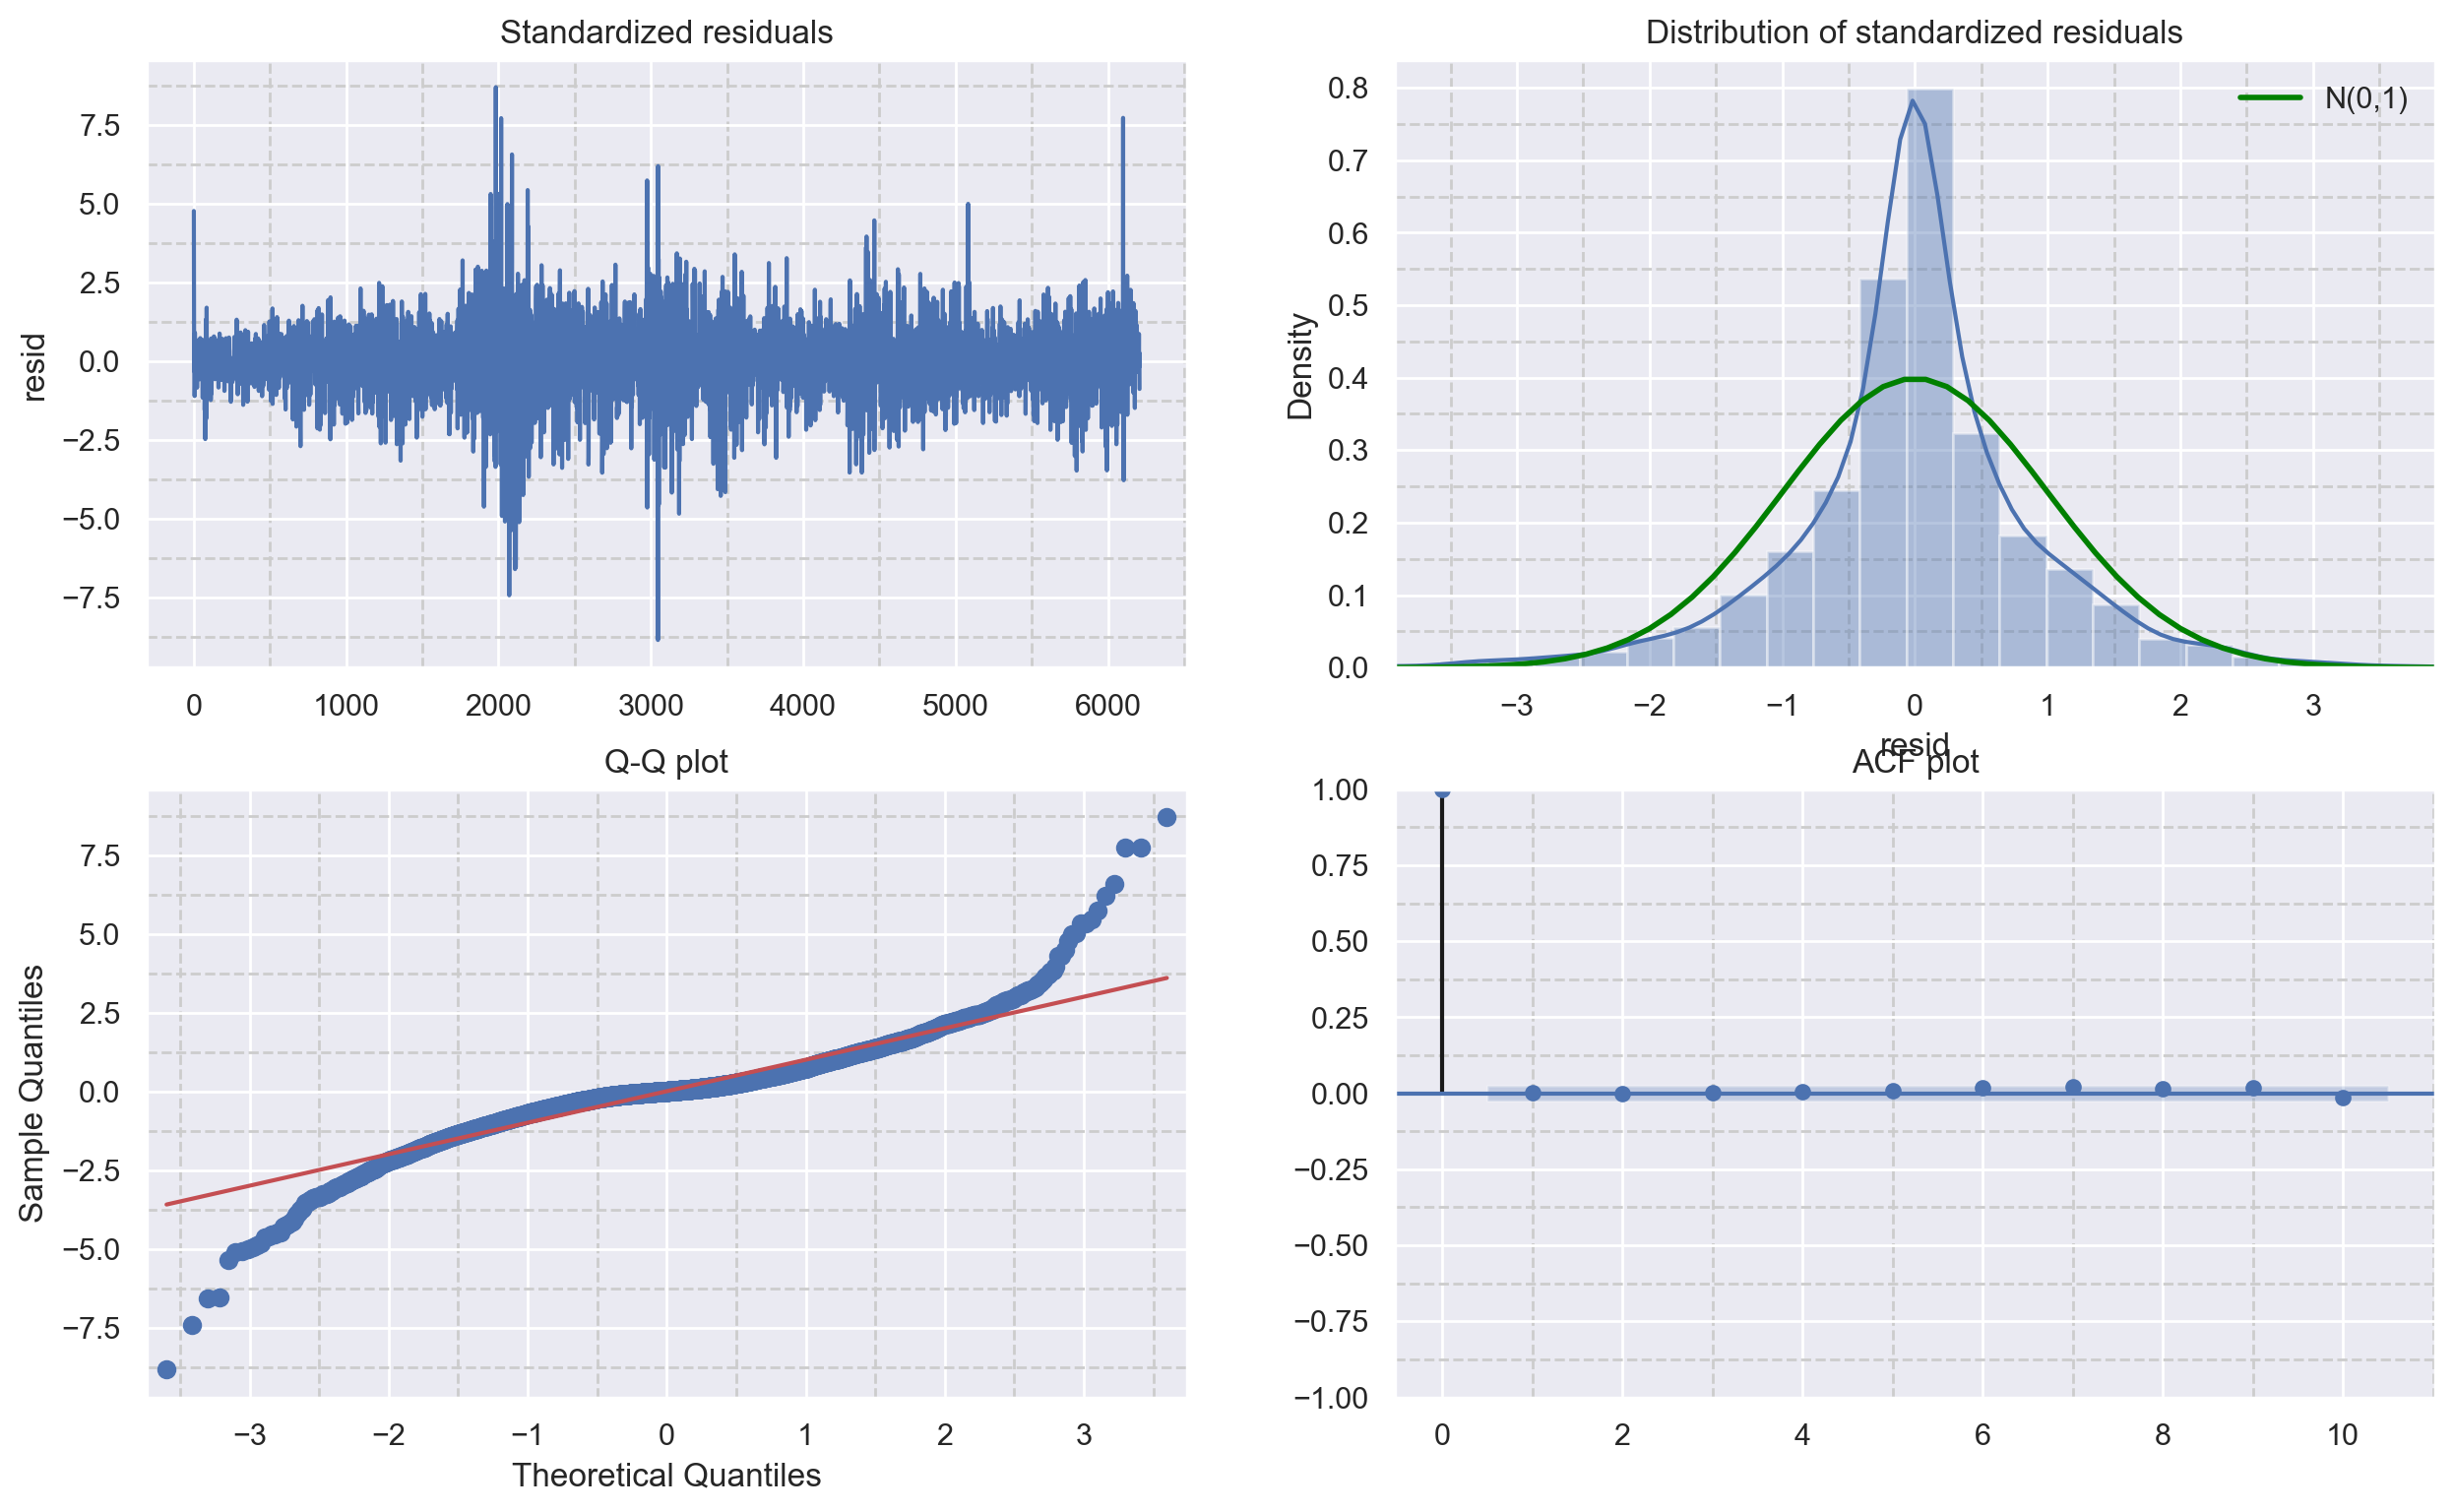

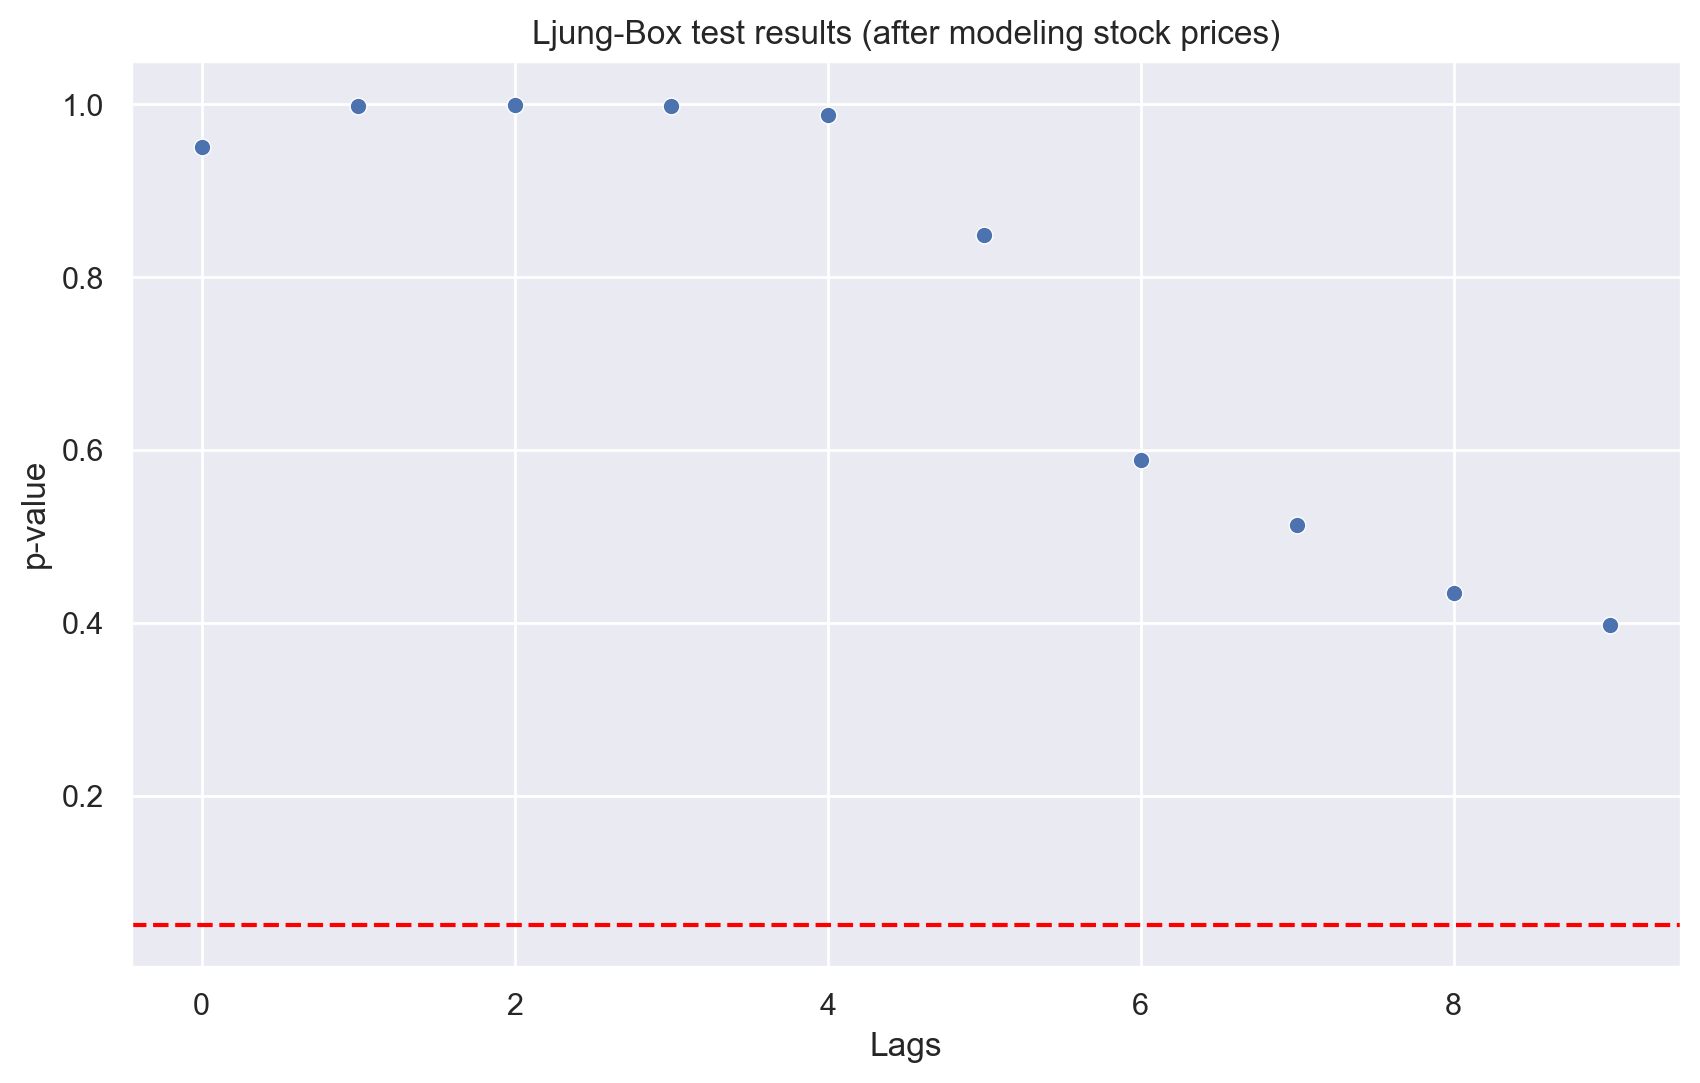

In [9]:
arf,garf = flt.pdmGarch_test(oil.copy(),y1='2019',y2='2020',lbl='Adj Close',plot=True)

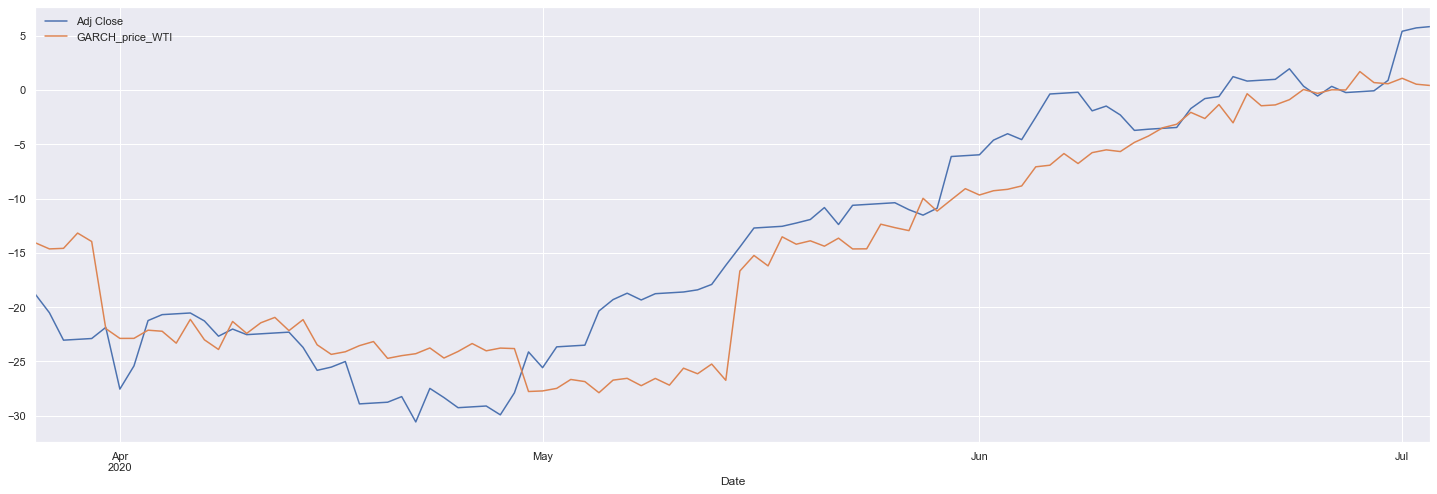

In [11]:
ret=su.garchIndicator(oil[-2000:].copy(), lbl='Adj Close', train_periods=1800,
                   forecast_periods=15, params=(3,0,3,'n'), label='WTI',simul=True)

ret[['Adj Close','GARCH_price_WTI']].tail(100).plot(figsize=(25,8))

# Enforcing stationarity for non-detrended time series

If the ADF test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary). 

If the KPSS test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). 

Alternatively, we can use the p-value to make the inference. If p-value is less than 0.05, we can reject the null hypothesis. And say that the series is not stationary.

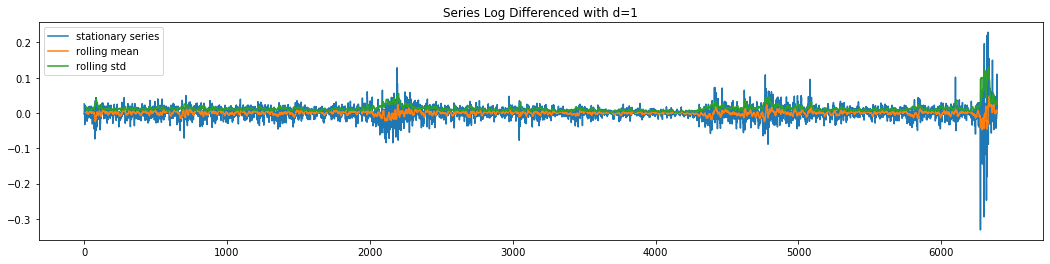

ACF First Lag AR(q):  1


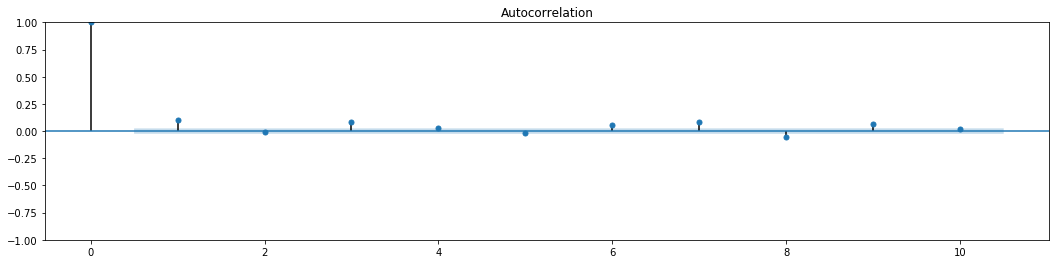

PACF First Lag MA(p):  1


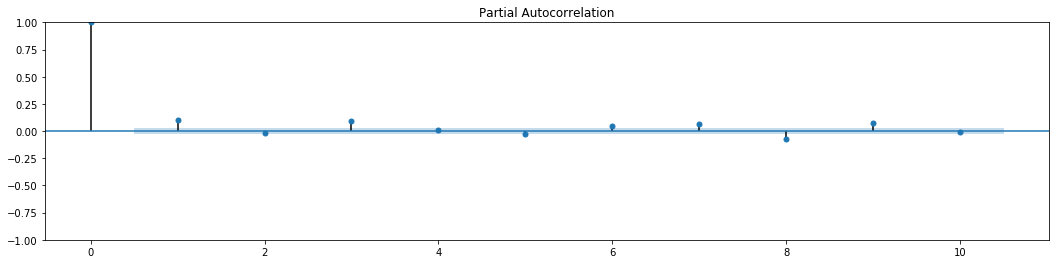

-------------------- Unit Root Tests -----------------------------
Results of Dickey-Fuller Test:
Test Statistic                -1.155751e+01
p-value                        3.331232e-21
#Lags Used                     3.300000e+01
Number of Observations Used    6.358000e+03
Critical Value (1%)           -3.431379e+00
Critical Value (5%)           -2.861995e+00
Critical Value (10%)          -2.567012e+00
dtype: float64
The series is stationary

Results of KPSS Test:
Test Statistic            0.148874
p-value                   0.100000
Lags Used                27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
The series is stationary
------------------------------------------------------------------


In [16]:
fd_,p_,q_=flt.seriesDifferencing(df2.copy(), diff=1,exp=False,lbl='adj_close',
                                tlog=True,n_lags=10,cin=0.05,w=12,fs=(18,9),plot=True)


Iteration:      1,   Func. Count:      9,   Neg. LLF: 38331.734189090224
Iteration:      2,   Func. Count:     22,   Neg. LLF: 18616.865467335898
Iteration:      3,   Func. Count:     31,   Neg. LLF: 3065190130.2735314
Iteration:      4,   Func. Count:     40,   Neg. LLF: 19245.655111439053
Iteration:      5,   Func. Count:     51,   Neg. LLF: 14284.368694528894
Iteration:      6,   Func. Count:     62,   Neg. LLF: 7723.0756399037855
Iteration:      7,   Func. Count:     71,   Neg. LLF: 7698.323122317028
Iteration:      8,   Func. Count:     80,   Neg. LLF: 7706.383838640595
Iteration:      9,   Func. Count:     89,   Neg. LLF: 7698.661104816218
Iteration:     10,   Func. Count:     98,   Neg. LLF: 7668.8941091791585
Iteration:     11,   Func. Count:    107,   Neg. LLF: 7625.0942749864535
Iteration:     12,   Func. Count:    116,   Neg. LLF: 7639.567622899284
Iteration:     13,   Func. Count:    125,   Neg. LLF: 7618.386364136039
Iteration:     14,   Func. Count:    134,   Neg. LLF: 76

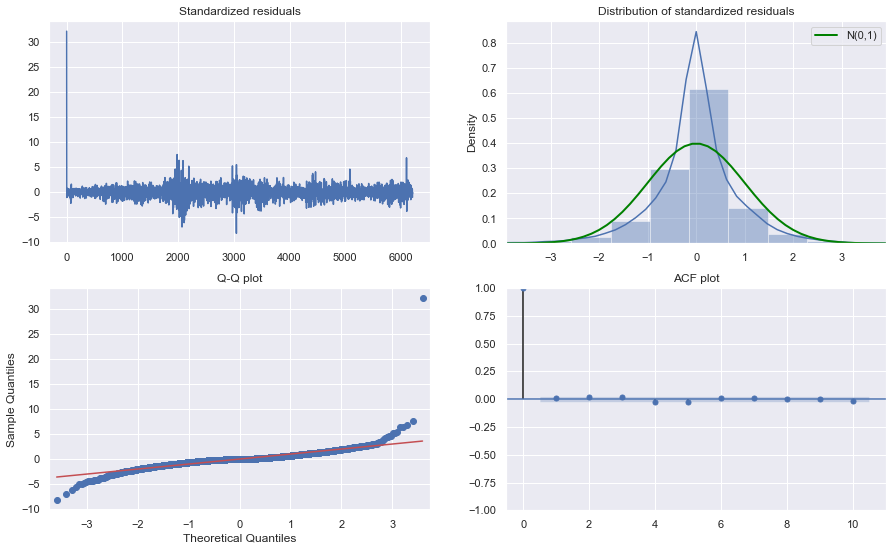

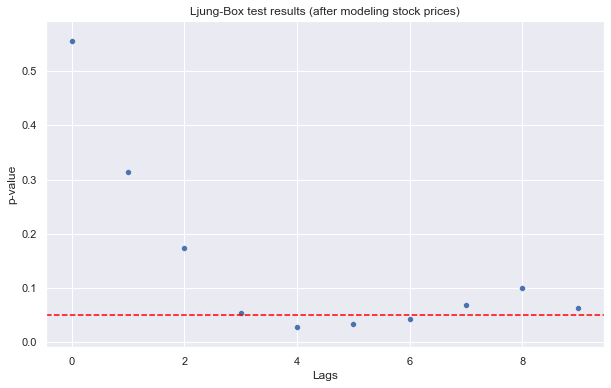

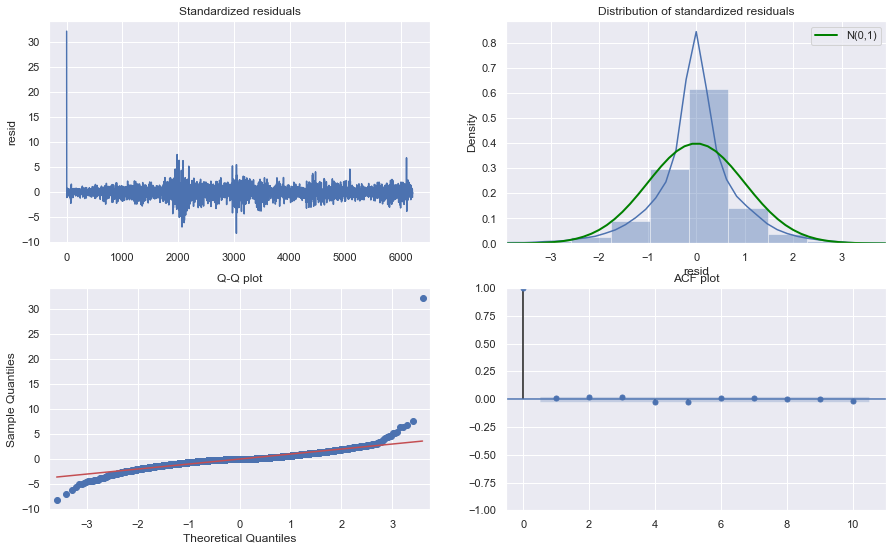

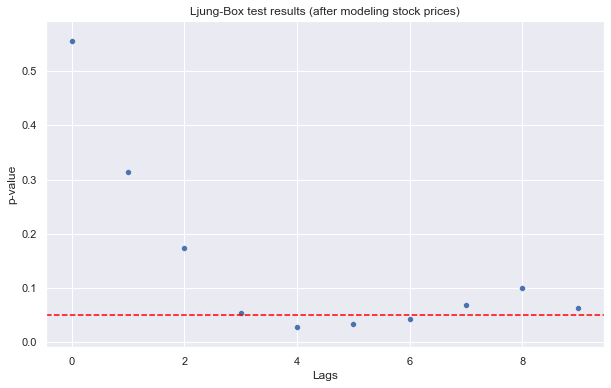

In [17]:
arf,garf = flt.pdmGarch_test(df2.copy(),y1='2019',y2='2020',lbl='adj_close',plot=True)

In [18]:
df=flt.garchPredict(df2.copy()[['adj_close']],horizon=5,params=(2,1,2,'n'),lbl='adj_close')

Iteration:      1,   Func. Count:      9,   Neg. LLF: 30274.185024837956
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5245056954.633243
Iteration:      3,   Func. Count:     31,   Neg. LLF: 9202.380742518602
Iteration:      4,   Func. Count:     41,   Neg. LLF: 7945.880638473317
Iteration:      5,   Func. Count:     50,   Neg. LLF: 8415.464891886955
Iteration:      6,   Func. Count:     60,   Neg. LLF: 7837.475031122662
Iteration:      7,   Func. Count:     69,   Neg. LLF: 7859.122726044209
Iteration:      8,   Func. Count:     78,   Neg. LLF: 9170.035399358738
Iteration:      9,   Func. Count:     87,   Neg. LLF: 7803.317277510876
Iteration:     10,   Func. Count:     96,   Neg. LLF: 7869.287675753483
Iteration:     11,   Func. Count:    105,   Neg. LLF: 7800.574970348782
Iteration:     12,   Func. Count:    114,   Neg. LLF: 7854.227662391888
Iteration:     13,   Func. Count:    123,   Neg. LLF: 7800.132625654904
Iteration:     14,   Func. Count:    132,   Neg. LLF: 7797.8241

In [19]:
df.tail(10)

adj_close
Date                 
2020-06-29  37.340000
2020-06-30  38.220000
2020-07-01  42.660000
2020-07-02  42.890000
2020-07-03  42.930000
2020-07-04  43.180731
2020-07-05  43.283762
2020-07-06  43.422552
2020-07-07  43.547016
2020-07-08  43.670860

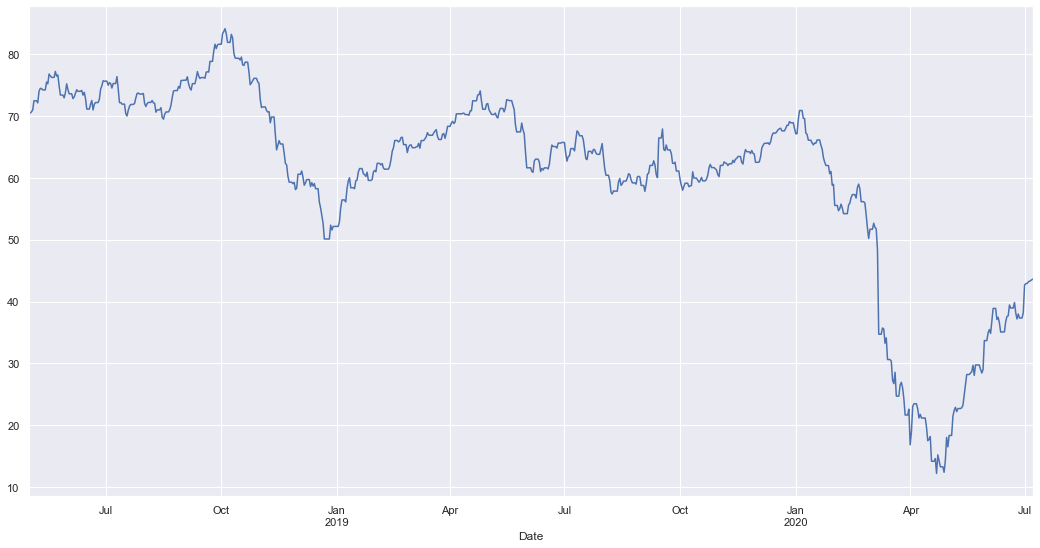

In [20]:
df.tail(800)['adj_close'].plot(figsize=(18,9))

# Load Contract Data and Create Continous Future

In [ ]:
sym='CL2'
trad_date='2020-07-03'
pr_label='Close'
dstart='1983-03-30'
dend='2022-04-22'

df=ng.getSingleFut(sym,freq='D')

#Define expiration rule
#expf = lambda x: tl.getNthWd(x,wd='friday',nth=3,bus_days=0,hformat=False)
#expf = lambda x: tl.getNhBD(x,start='first',bus_days=10,hformat=False)
#expf = lambda x: tl.getNthWd(x,wd='friday',nth=3,bus_days=1,hformat=False,month_shift=-1)
# CL expiration at 20 of previous month
expf = lambda x: tl.getNhBD(x,start=20,bus_days=0,hformat=False,month_shift=-1) 
df=df[df['Year']<'2025']

df=tl.getFutMonthsExp(df,expf=expf)
#For single contract evaluation
dfc2=df.copy()

dfc=ts.createContFut(df,trading_date=trad_date, label=pr_label, method='panama-back-adj')
dfc.head(5)

### Plot Term Structure and Implied Yield of Product from Trading Date

In [ ]:
pvt,avgp,avgv,avgoi=ts.mk_termStruct(df,trading_date=trad_date,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=trad_date,dt_end=dend,
                    lbl_tit=pr_label + ' Price',lbl_y='Price', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


In [ ]:
lbl_IYield='IYield'
df=ts.getImpliedYield(df,lbl_price=pr_label)
pvt,avgp,avgv,avgoi=ts.mk_termStruct(df,trading_date=trad_date,lbl1=lbl_IYield,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=trad_date,dt_end=dend,
                    lbl_tit=lbl_IYield + 'of Price',lbl_y='lbl_IYield', plsrs=False)


### Historical Term Structure of Prices

In [ ]:
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year',perc=True) 
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=pr_label + ' Price Percentiles',lbl_y='Price Percentiles', plsrs=False)


In [ ]:
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year') 
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=pr_label + ' Price',lbl_y='Price', plsrs=False)


### Historical Term Structure of Returns


In [ ]:
ret_label='Returns'
dfc=ts.getLogReturns(dfc,ret_label=ret_label,pr_label=pr_label)
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=ret_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit='Log Returns',lbl_y='Log Returns', plsrs=False)


### Historical Term Structure of Skew

In [ ]:
roll_window=20
dfc=ts.df_rolling_skew(dfc,lbl_rets=ret_label,roll_win=roll_window)
skew_label='Skew-'+str(roll_window)
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=skew_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit='Skew of Returns',lbl_y='Skew of Returns', plsrs=False)


### Historical Term Structure of Volatility

In [ ]:
vol_label='rvol'
vol_desc='Realized'

rvol, pk_20, pk_60, pk_120 = ts.getFutVols(dfc, years=51)
dfc=ts.plotFutVols(dfc,rvol, pk_20, pk_60, pk_120)

pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=vol_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=vol_desc+' Volatility',lbl_y='Volatility', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)
